<h1>THE BATTLE OF NEIGHBOURHOODS</h1>

<h1><font color='green'>APPLIED DATA SCIENCE CAPESTONE PROJECT</font></h1>

## TABLE OF CONTENTS :
##### 1.) [BUSINESS PROBLEM](#introduction)
##### 2.) [DATA NEEDED](#dataneeded)
##### 3.) [METHODS](#method)
##### 4.) [ANALYSE & VISUALIZE](#analyse&visualize)
##### 5.) [CLUSTERING OF NEIGHBOURHOODS](#clustering)
##### 6.) [CLUSTER EXAMINATION](#cexamination)
##### 7.) [DISCUSSION - BAR GRAPH OF TOP 5 VENUES](#bargraphs)
##### 8.) [CONCLUSION](#conclusion)
# -----------------------------------------------------------------------------------------------------------------------------------------

# BUSINESS PROBLEM : <a name="introduction"></a>

The following project is on the neighbourhoods of Chennai. 
The following project helps people to start a Hotel, Gym, Shopping Mall etc in a perfect spot as wished.

The **Foursquare API** is used to access the venues in the neighbourhoods.

The Foursquare Places API provides location based experiences with diverse information about venues, users, photos, and check-ins.

Here only a min amount of venues ar obtaines. So we analyse areas with countable no. of venues.

**k-means Clustering Algorithm :** used to undergo Clustering of Neighbourhoods. 

**Silhouette Score :** Gives optimal number of clusters.

**Folium visualization library :** Used to visualize the clusters superimposed on the map of Chennai city.

##### LIBRARY IMPORTATION :

In [137]:
!pip install folium
import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Libraries imported.


# -----------------------------------------------------------------------------------------------------------------------------------------

# DATA NEEDED : <a name="dataneeded"></a>

**Dataset with the list of locations in chennai along with their Latitude and Longitude:** https://chennaiiq.com/chennai/latitude_longitude_areas.asp

In [3]:
url = 'https://chennaiiq.com/chennai/latitude_longitude_areas.asp'

html = requests.get(url)
print(html)

<Response [200]>


**Response value of 200:** The process was successful.

**BeautifulSoup library:** Used to parse the html file in order to make it easier to access.

In [4]:
soup = BeautifulSoup(html.text, 'html.parser')
table = soup.find("table", attrs={"class": "TBox"})

# -----------------------------------------------------------------------------------------------------------------------------------------
## DATA COLLECTION:

In [138]:
table_data = []
index = ['S.No.', 'Location', 'Latitude', 'Longitude']
for tr in table.find_all("tr", attrs={"class": "tab"}):
    t_row = {}
    for td, th in zip(tr.find_all("td"), index): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

chennai_data = pd.DataFrame(table_data[:-1], columns=index)
chennai_data.drop(columns=['S.No.'], inplace=True)
chennai_data.at[0,'Location'] = 'Adyar Bus Debot'
chennai_data.rename(columns={'Location': 'Neighbourhood'}, inplace=True)
print(chennai_data.shape)
chennai_data.head(11)

(105, 3)


,Neighbourhood,Latitude,Longitude
0,Adyar Bus Debot,"12°59'50"" N","80°15'25"" E"
1,Adyar Signal,"13°00'23"" N","80°15'27"" E"
2,Alandur,"13°00'28"" N","80°12'35"" E"
3,Ambattur,"13°06'36"" N","80°10'12"" E"
4,Anna Arch,"13°04'28"" N","80°13'06"" E"
5,Anna Nagar Roundana,"13°05'04"" N","80°13'05"" E"
6,Anna Nagar West Terminus,"13°05'35"" N","80°11'55"" E"
7,Anna Statue,"13°04'05"" N","80°16'19"" E"
8,Anna University Entrance,"13°00'29"" N","80°14'06"" E"
9,Avadi,"13°07'13"" N","80°06'36"" E"


# -----------------------------------------------------------------------------------------------------------------------------------------

### CONVERSION OF deg'min'sec" TO DECIMALS:

In [139]:
def dms2dd(s):
    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','W'):
        dd*= -1
    return dd

chennai_data['Latitude'] = chennai_data['Latitude'].apply(dms2dd)
chennai_data['Longitude'] = chennai_data['Longitude'].apply(dms2dd)
print(chennai_data.shape)
chennai_data.head(11)

(105, 3)


,Neighbourhood,Latitude,Longitude
0,Adyar Bus Debot,12.997222,80.256944
1,Adyar Signal,13.006389,80.257500
2,Alandur,13.007778,80.209722
3,Ambattur,13.110000,80.170000
4,Anna Arch,13.074444,80.218333
5,Anna Nagar Roundana,13.084444,80.218056
6,Anna Nagar West Terminus,13.093056,80.198611
7,Anna Statue,13.068056,80.271944
8,Anna University Entrance,13.008056,80.235000
9,Avadi,13.120278,80.110000


**Folium Library:** Visualization of the Neighbourhoods.

**Geolocator library:** Gives latitude and longitude of Chennai .

In [140]:
address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The Geo-coordinates: {}, {}.'.format(latitude, longitude))

The Geo-coordinates: 13.0836939, 80.270186.


#### Chennai Map:

In [141]:
# create map of Toronto using latitude and longitude values
chennai_map = folium.Map(location=[latitude, longitude], zoom_start=11)    
chennai_map

#### Chennai Map with the neighbourhoods superimposed on top:

In [142]:
# add neighbourhood markers to map
for lat, lng, location in zip(chennai_data['Latitude'], chennai_data['Longitude'], chennai_data['Neighbourhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chennai_map)  

chennai_map

# -----------------------------------------------------------------------------------------------------------------------------------------

# DEFINITION OF FOURSQUARE CREDENTIALS & VERSION: 

In [143]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20210802' # Foursquare API version

#### EXPLORATION OF NEIGHBOURHOODS:

For 100 most popular places in the neighbourhood around 500 meters.

In [144]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Storing the venues data returned in the chennai_venues pandas dataframe:

In [145]:
chennai_venues = getNearbyVenues(names = chennai_data['Neighbourhood'],
                                 latitudes = chennai_data['Latitude'],
                                 longitudes = chennai_data['Longitude']
                                 )

print(chennai_venues.shape)
chennai_venues.head(11)

(1167, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.997222,80.256944,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant
4,Adyar Bus Debot,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store
5,Adyar Bus Debot,12.997222,80.256944,Barbeque N Biryani,12.995907,80.256011,BBQ Joint
6,Adyar Bus Debot,12.997222,80.256944,Subway,12.999040,80.254743,Sandwich Place
7,Adyar Bus Debot,12.997222,80.256944,Domino's Pizza,13.001470,80.256626,Pizza Place
8,Adyar Bus Debot,12.997222,80.256944,Vasantha Bhavan,13.000444,80.256374,Indian Restaurant
9,Adyar Bus Debot,12.997222,80.256944,The Rock,12.996585,80.255900,Asian Restaurant


**Total Venues:** 1130

##### Checking the number of venues returned per neighbourhood:

In [146]:
chennai_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
AVM Studio,5,5,5,5,5,5
Adyar Bus Debot,16,16,16,16,16,16
Adyar Signal,35,35,35,35,35,35
Alandur,14,14,14,14,14,14
Ambattur,2,2,2,2,2,2
Anna Arch,14,14,14,14,14,14
Anna Nagar Roundana,21,21,21,21,21,21
Anna Nagar West Terminus,8,8,8,8,8,8
Anna Statue,13,13,13,13,13,13


From the above dataframe we can see that Taj Coromandal returned the highest number of venues i.e. 50. Now lets check the unique categories of all the venues returned.

In [147]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 152 uniques categories.


# -----------------------------------------------------------------------------------------------------------------------------------------

# METHODS: <a name="method"></a>

**Neighbourhood Data of Chennai:** (105 neighbourhoods).

We also have the most popular venues in each neighbourhood obtained using Foursquare API. 

**Total Venues:** 1130 

**Unique Category:** 145

We have neighbourhoods with < 10 venues. So we will consider only a good count.

**One hot encoding:** Usedto find the **10 most common venue category** in each neighbourhood. 
**K - Nearest Neighbour:** Clustering of one hot encoded dataset. 

**Silhouette Score:** To find the optimal number of clusters

# -----------------------------------------------------------------------------------------------------------------------------------------

# ANALYSE & VISUALIZE : <a name="analyse&visualize"></a>

First, lets visualize the number of venues obtained in all the neighbourhoods of Chennai.

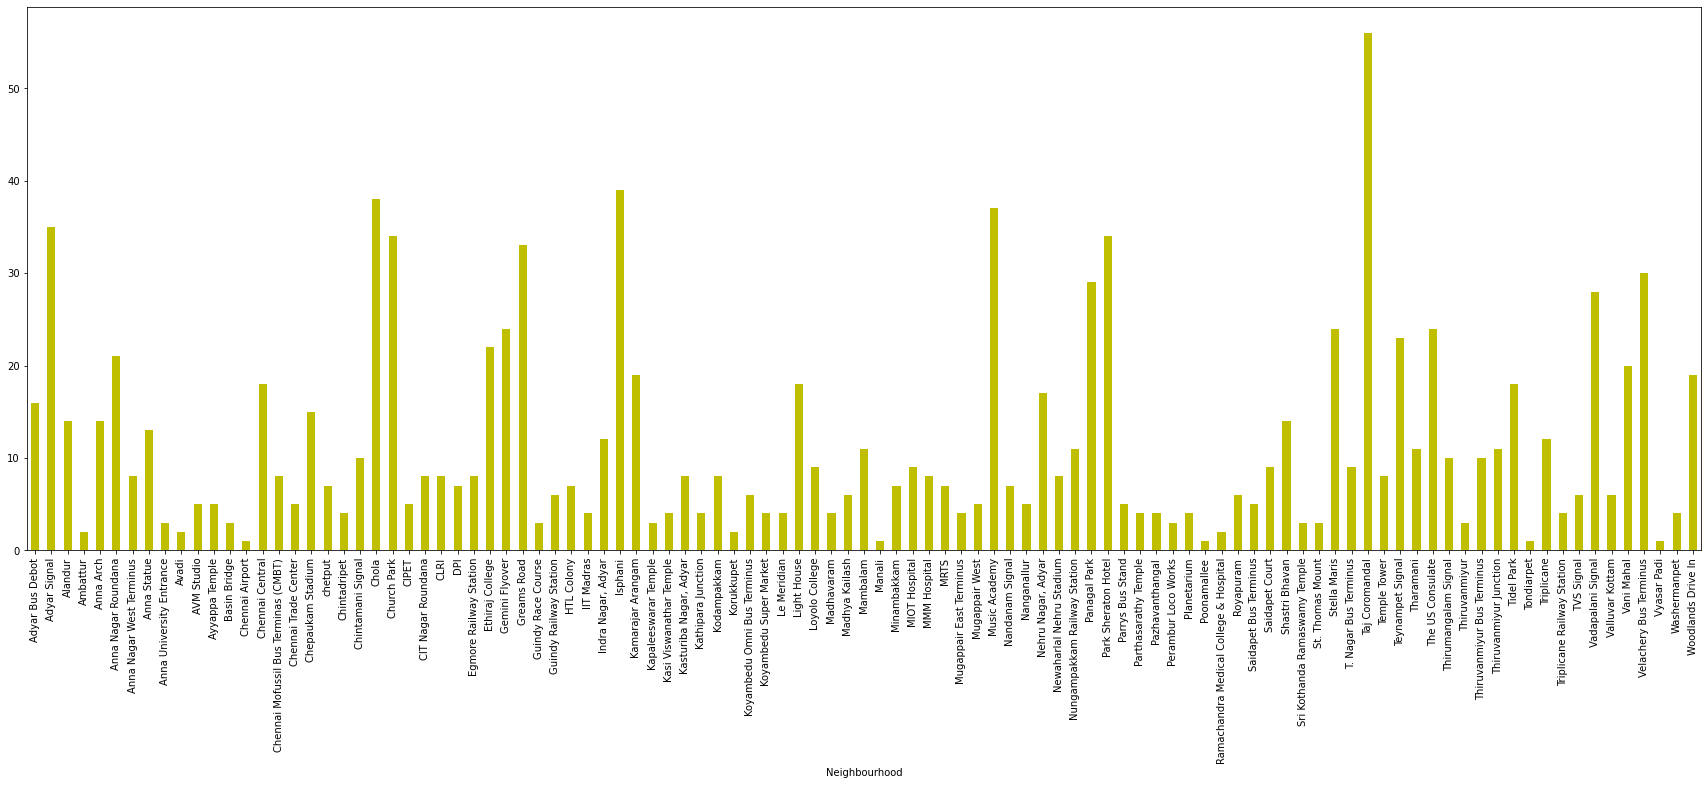

In [148]:
df = chennai_venues.groupby(['Neighbourhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(30,10),color='y')

#### Removal of Neighbourhoods with venues<10 for betterness :

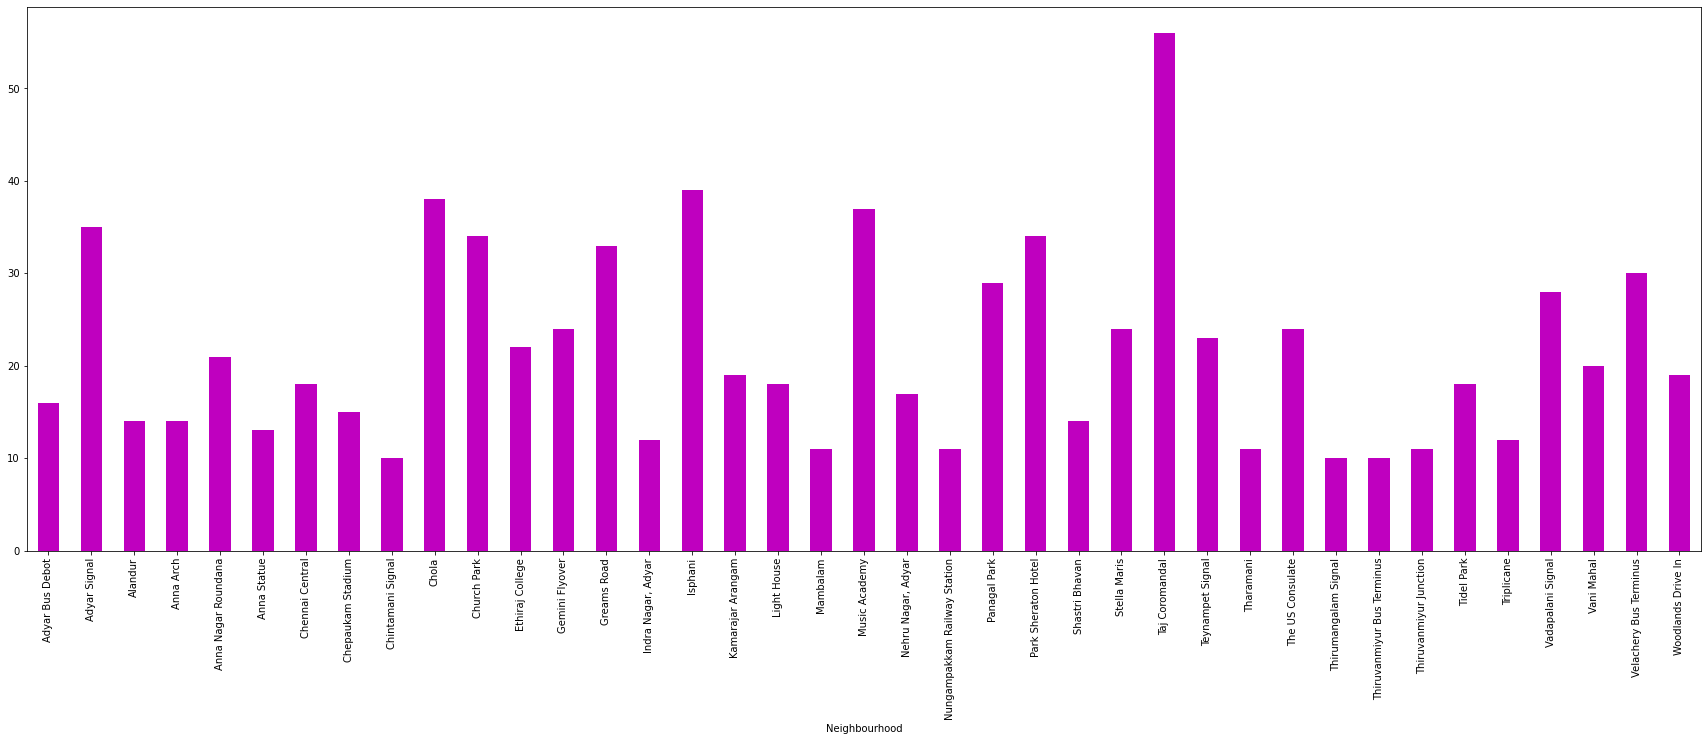

In [149]:
df = df[df >= 10]
df.plot.bar(figsize=(30,10),color='m')

**chennai_venues_top:** To obtain the neighbourhoods with 10+ venues and the venues with their details included.

In [150]:
chennai_venues_top = chennai_venues[chennai_venues['Neighbourhood'].isin(df.index.tolist())]
chennai_venues_top.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.997222,80.256944,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant
4,Adyar Bus Debot,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store


### One hot encoding:

In [151]:
chennai_onehot = pd.get_dummies(chennai_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
chennai_onehot['Neighbourhood'] = chennai_venues_top['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = chennai_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighbourhood')))
chennai_onehot = chennai_onehot.reindex(columns = fixed_columns)

print(chennai_onehot.shape)
chennai_onehot.head()

(844, 112)


,Neighbourhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Station,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,General Entertainment,Grocery Store,Gym,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pharmacy,Pizza Place,Platform,Pool,Print Shop,Pub,Ramen Restaurant,Recreation Center,Restaurant,Road,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Sporting Goods Shop,Steakhouse,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adyar Bus Debot,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Grouping of Data:

In [152]:
chennai_grouped = chennai_onehot.groupby('Neighbourhood').mean().reset_index()
print(chennai_grouped.shape)
chennai_grouped.head()

(39, 112)


,Neighbourhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Station,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,General Entertainment,Grocery Store,Gym,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pharmacy,Pizza Place,Platform,Pool,Print Shop,Pub,Ramen Restaurant,Recreation Center,Restaurant,Road,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Sporting Goods Shop,Steakhouse,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.125000,0.0,0.0,0.0625,0.062500,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0625,0.0,0.062500,0.0,0.062500,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.125000,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.187500,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.062500,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0625,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Adyar Signal,0.0,0.0,0.000000,0.0,0.0,0.028571,0.0,0.028571,0.0,0.0,0.0000,0.028571,0.0,0.000000,0.0,0.0,0.0,0.028571,0.0,0.0,0.0000,0.0,0.000000,0.0,0.028571,0.000000,0.0,0.000000,0.057143,0.0,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.057143,0.028571,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.000000,0.000000,0.028571,0.285714,0.028571,0.0,0.028571,0.028571,0.0,0.0,0.0,0.028571,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.028571,0.0,0.000000,0.0,0.0,0.0,0.057143,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.028571,0.0,0.0,0.0000,0.000000,0.0,0.0,0.028571,0.0,0.028571,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.057143,0.0
2,Alandur,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.071429,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.142857,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.071429,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.142857,0.071429,0.000000,0.142857,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.071429,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.071429,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.142857,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Anna Arch,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.071429,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,0.0000,0.0,0.000000,0.0,0.071429,0.000000,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.071429,0.142857,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.071429,0.0,0.000000,0.0,0.000000

In [153]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**neighbourhoods_venues_sorted:** 10 most common venues in each neighbourhood stored in the new pandas dataframe

In [154]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = chennai_grouped['Neighbourhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Pizza Place,Café,Bus Station,Breakfast Spot,Sandwich Place,Fruit & Vegetable Store
1,Adyar Signal,Indian Restaurant,North Indian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Electronics Store,Bakery,Dessert Shop,Movie Theater,Café,Fast Food Restaurant
2,Alandur,Indian Restaurant,South Indian Restaurant,Bus Station,Hotel,Restaurant,Electronics Store,Metro Station,Bar,Hotel Bar,Airport
3,Anna Arch,Fast Food Restaurant,Clothing Store,Café,Mediterranean Restaurant,Multiplex,Pub,Bookstore,Electronics Store,Bakery,Shopping Mall
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Clothing Store,South Indian Restaurant,Coffee Shop,Electronics Store,Fast Food Restaurant,Bookstore,Middle Eastern Restaurant,Bakery


# -----------------------------------------------------------------------------------------------------------------------------------------

# CLUSTERING OF NEIGHBOURHOODS:<a name="clustering"></a>

**Clustering Technique:** k-nearest

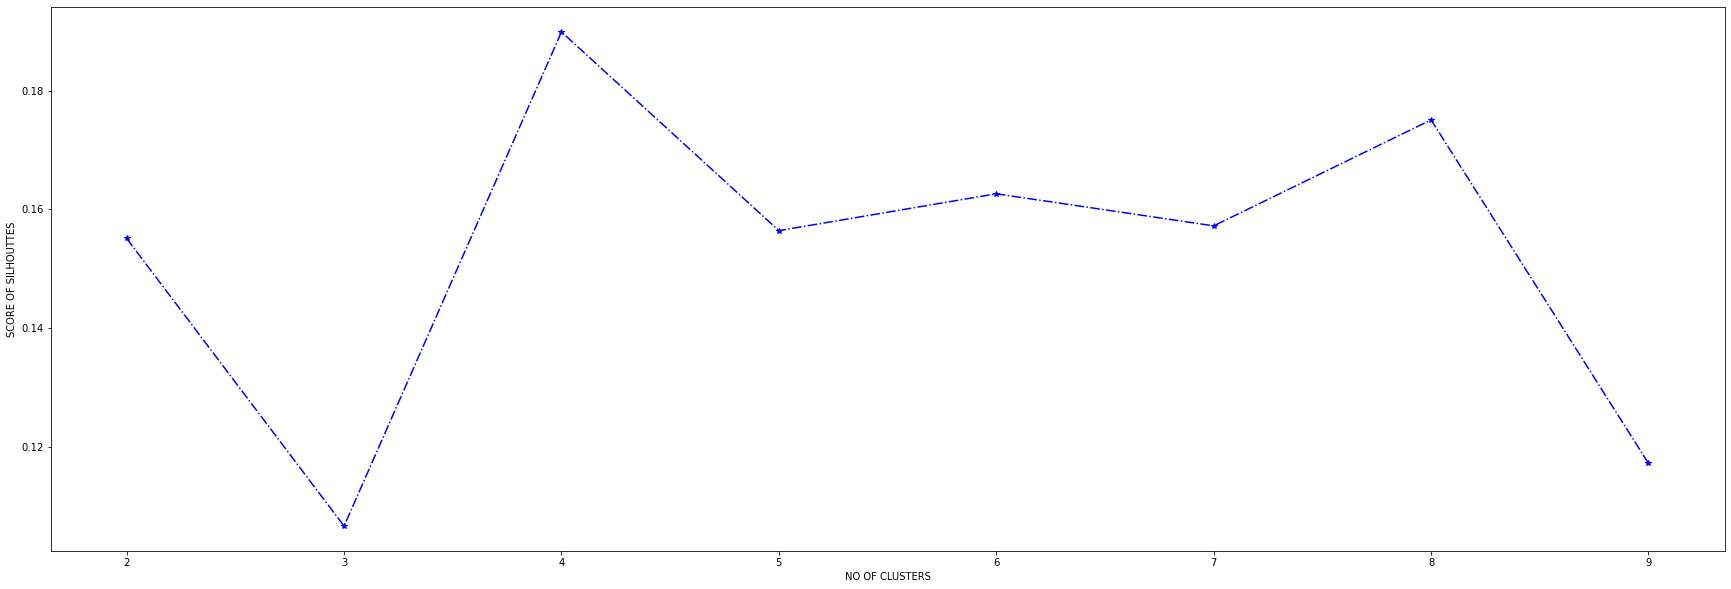

In [155]:
chennai_grouped_clustering = chennai_grouped.drop('Neighbourhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(chennai_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(chennai_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(30,10))
plt.plot(np.arange(2, max_score), scores, '-.b*')
plt.xlabel("NO OF CLUSTERS")
plt.ylabel("SCORE OF SILHOUTTES")
plt.xticks(np.arange(2, max_score))
plt.show()

**Best Silhoutte Score:** 8

So,

**No. Of Clusters:** 8

In [156]:
# select best number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 7, 6, 0, 8, 0, 0, 0, 3], dtype=int32)

Add the cluster labels to the **neighbourhoods_venues_sorted** dataframe. And lets create a new datframe **chennai_merged** which has the neighbourhood details, cluster labels and the 10 most common venues in that neighbourhood.

In [157]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chennai_merged = chennai_venues_top[chennai_venues_top.columns[0:3]].drop_duplicates()
chennai_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
chennai_merged = chennai_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

chennai_merged.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,12.997222,80.256944,0,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Pizza Place,Café,Bus Station,Breakfast Spot,Sandwich Place,Fruit & Vegetable Store
1,Adyar Signal,13.006389,80.257500,0,Indian Restaurant,North Indian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Electronics Store,Bakery,Dessert Shop,Movie Theater,Café,Fast Food Restaurant
2,Alandur,13.007778,80.209722,7,Indian Restaurant,South Indian Restaurant,Bus Station,Hotel,Restaurant,Electronics Store,Metro Station,Bar,Hotel Bar,Airport
3,Anna Arch,13.074444,80.218333,6,Fast Food Restaurant,Clothing Store,Café,Mediterranean Restaurant,Multiplex,Pub,Bookstore,Electronics Store,Bakery,Shopping Mall
4,Anna Nagar Roundana,13.084444,80.218056,0,Indian Restaurant,Chinese Restaurant,Clothing Store,South Indian Restaurant,Coffee Shop,Electronics Store,Fast Food Restaurant,Bookstore,Middle Eastern Restaurant,Bakery


# -----------------------------------------------------------------------------------------------------------------------------------------

# CLUSTER EXAMINATION: <a name="cexamination"></a>

<h3>Cluster 1</h3>

In [158]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Pizza Place,Café,Bus Station,Breakfast Spot,Sandwich Place,Fruit & Vegetable Store
1,Adyar Signal,Indian Restaurant,North Indian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Electronics Store,Bakery,Dessert Shop,Movie Theater,Café,Fast Food Restaurant
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Clothing Store,South Indian Restaurant,Coffee Shop,Electronics Store,Fast Food Restaurant,Bookstore,Middle Eastern Restaurant,Bakery
6,Chennai Central,Indian Restaurant,Train Station,Platform,Bookstore,Metro Station,Bus Station,Café,Sandwich Place,Vegetarian / Vegan Restaurant,Hotel
7,Chepaukam Stadium,Indian Restaurant,Mediterranean Restaurant,Electronics Store,Bar,Breakfast Spot,Multiplex,Music Store,General Entertainment,Café,Hotel
8,Chintamani Signal,Indian Restaurant,Restaurant,Bakery,Electronics Store,Middle Eastern Restaurant,Coffee Shop,Gym,Hotel Bar,Comfort Food Restaurant,Concert Hall
24,Shastri Bhavan,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Theater,Coffee Shop,Hotel,Convenience Store,Multicuisine Indian Restaurant,Asian Restaurant,Diner
30,Thirumangalam Signal,Indian Restaurant,Jewelry Store,Smoke Shop,Vegetarian / Vegan Restaurant,Mobile Phone Shop,Café,Print Shop,Pizza Place,Asian Restaurant,Food Court
37,Velachery Bus Terminus,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Restaurant,Accessories Store,Shoe Store,Juice Bar,Kerala Restaurant,Multiplex,Coffee Shop


In [159]:
cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Indian Restaurant                9
Coffee Shop                      5
Café                             5
Fast Food Restaurant             4
Electronics Store                4
Hotel                            3
Asian Restaurant                 3
Bakery                           3
Chinese Restaurant               3
Vegetarian / Vegan Restaurant    3
dtype: int64


<h3>---------------------------------------------------------------------------------------------------------------------------</h3>

<h3>Cluster 2</h3>

In [179]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Light House,Fast Food Restaurant,Food Court,Coffee Shop,Department Store,Bar,Sandwich Place,Sculpture Garden,Shopping Mall,Beach,Multiplex
28,Tharamani,Café,Fast Food Restaurant,Indian Restaurant,Bakery,Office,Sandwich Place,Food Court,Vegetarian / Vegan Restaurant,Gym,Electronics Store
33,Tidel Park,Food Court,Office,Café,Sandwich Place,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Bus Station,Platform,Vegetarian / Vegan Restaurant


In [178]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Sandwich Place                   3
Fast Food Restaurant             3
Food Court                       3
Vegetarian / Vegan Restaurant    2
Indian Restaurant                2
Café                             2
Office                           2
Chinese Restaurant               1
Coffee Shop                      1
Department Store                 1
dtype: int64


<h3>---------------------------------------------------------------------------------------------------------------------------</h3>

<h3>Cluster 3</h3>

In [162]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Indra Nagar, Adyar",Café,Women's Store,Sandwich Place,Juice Bar,Pizza Place,Indian Restaurant,Chinese Restaurant,Breakfast Spot,Bookstore,Platform
20,"Nehru Nagar, Adyar",Café,Indian Restaurant,Pizza Place,Chinese Restaurant,Women's Store,Bookstore,Ice Cream Shop,South Indian Restaurant,Department Store,Sandwich Place


In [163]:
cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Sandwich Place        2
Indian Restaurant     2
Bookstore             2
Chinese Restaurant    2
Café                  2
Pizza Place           2
Women's Store         2
Platform              1
Juice Bar             1
Ice Cream Shop        1
dtype: int64


<h3>---------------------------------------------------------------------------------------------------------------------------</h3>

<h3>Cluster 4</h3>

In [164]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Chola,Indian Restaurant,Hotel,Ice Cream Shop,Restaurant,Concert Hall,Tea Room,Lounge,Comfort Food Restaurant,Dessert Shop,Chinese Restaurant
11,Ethiraj College,Hotel,Indian Restaurant,Pizza Place,Juice Bar,Kebab Restaurant,Café,Korean Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Donut Shop
19,Music Academy,Indian Restaurant,Hotel,Café,Concert Hall,Restaurant,Women's Store,Mexican Restaurant,Comfort Food Restaurant,Dessert Shop,Electronics Store
25,Stella Maris,Indian Restaurant,Hotel,Women's Store,Bar,Italian Restaurant,Juice Bar,Kerala Restaurant,Garden,Mexican Restaurant,Fast Food Restaurant
27,Teynampet Signal,Indian Restaurant,Hotel,Lounge,Pub,Italian Restaurant,Pizza Place,Bowling Alley,Diner,Clothing Store,Juice Bar


In [180]:
cluster4 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Indian Restaurant          5
Hotel                      5
Mexican Restaurant         3
Juice Bar                  3
Women's Store              2
Dessert Shop               2
Comfort Food Restaurant    2
Restaurant                 2
Café                       2
Lounge                     2
dtype: int64


<h3>---------------------------------------------------------------------------------------------------------------------------</h3>

<h3>Cluster 5</h3>

In [166]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Church Park,Multiplex,Indian Restaurant,Chinese Restaurant,Café,Movie Theater,Middle Eastern Restaurant,Bakery,Fast Food Restaurant,Bengali Restaurant,Park
13,Greams Road,Multiplex,Indian Restaurant,Café,Middle Eastern Restaurant,Bakery,Juice Bar,Movie Theater,Bistro,Mexican Restaurant,Pub
31,Thiruvanmiyur Bus Terminus,Indian Restaurant,Juice Bar,Multiplex,Hotel Bar,Hotel,Chinese Restaurant,Gym,Pizza Place,Department Store,Diner
32,Thiruvanmiyur Junction,Indian Restaurant,Multiplex,Chinese Restaurant,Hotel Bar,Hotel,Gym,Pharmacy,Pizza Place,Clothing Store,Athletics & Sports
35,Vadapalani Signal,Multiplex,Fast Food Restaurant,Clothing Store,Indian Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,South Indian Restaurant,Hotel,Music Store,Cosmetics Shop


In [167]:
cluster5 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Multiplex                    5
Indian Restaurant            5
Chinese Restaurant           3
Hotel                        3
Middle Eastern Restaurant    2
Juice Bar                    2
Movie Theater                2
Gym                          2
Pizza Place                  2
Bakery                       2
dtype: int64


<h3>---------------------------------------------------------------------------------------------------------------------------</h3>

<h3>Cluster 6</h3>

In [168]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Mambalam,Clothing Store,Jewelry Store,Asian Restaurant,Miscellaneous Shop,Road,Boutique,South Indian Restaurant,Indian Restaurant,Arts & Crafts Store,Concert Hall
22,Panagal Park,Clothing Store,Indian Restaurant,Jewelry Store,Pizza Place,BBQ Joint,Boutique,Café,Coffee Shop,Dessert Shop,Fast Food Restaurant


In [169]:
cluster6 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Indian Restaurant          2
Boutique                   2
Jewelry Store              2
Clothing Store             2
Concert Hall               1
BBQ Joint                  1
Fast Food Restaurant       1
Miscellaneous Shop         1
Arts & Crafts Store        1
South Indian Restaurant    1
dtype: int64


<h3>---------------------------------------------------------------------------------------------------------------------------</h3>

<h3>Cluster 7</h3>

In [171]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Anna Arch,Fast Food Restaurant,Clothing Store,Café,Mediterranean Restaurant,Multiplex,Pub,Bookstore,Electronics Store,Bakery,Shopping Mall


In [172]:
cluster7 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Electronics Store           1
Mediterranean Restaurant    1
Pub                         1
Multiplex                   1
Fast Food Restaurant        1
Bookstore                   1
Clothing Store              1
Café                        1
Bakery                      1
Shopping Mall               1
dtype: int64


<h3>---------------------------------------------------------------------------------------------------------------------------</h3>

<h3>Cluster 8</h3>

In [173]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Alandur,Indian Restaurant,South Indian Restaurant,Bus Station,Hotel,Restaurant,Electronics Store,Metro Station,Bar,Hotel Bar,Airport
12,Gemini Flyover,Indian Restaurant,Hotel,Coffee Shop,Nightclub,Sandwich Place,Bar,Lounge,Department Store,Chinese Restaurant,Park
15,Isphani,Indian Restaurant,Chinese Restaurant,Café,Hotel,Coffee Shop,Lounge,Nightclub,Pizza Place,South Indian Restaurant,Sandwich Place
16,Kamarajar Arangam,Indian Restaurant,Café,Hotel,Lounge,Pizza Place,BBQ Joint,Nightclub,Coffee Shop,Park,Bistro
21,Nungampakkam Railway Station,Chinese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Department Store,Clothing Store,Italian Restaurant,Bus Station,South Indian Restaurant,Indian Restaurant
23,Park Sheraton Hotel,Café,Hotel,Chinese Restaurant,Italian Restaurant,Nightclub,Dessert Shop,Restaurant,Japanese Restaurant,Coffee Shop,Indian Restaurant
26,Taj Coromandal,Indian Restaurant,Café,Chinese Restaurant,Italian Restaurant,Sandwich Place,Asian Restaurant,Ice Cream Shop,Hotel,Fast Food Restaurant,Dessert Shop
29,The US Consulate,Indian Restaurant,Hotel,Coffee Shop,Nightclub,Sandwich Place,BBQ Joint,Lounge,Department Store,Chinese Restaurant,Park
36,Vani Mahal,Hotel,Indian Restaurant,Coffee Shop,Clothing Store,Department Store,Bar,Recreation Center,BBQ Joint,Pub,Music Venue
38,Woodlands Drive In,Indian Restaurant,Hotel,Nightclub,BBQ Joint,Lounge,Department Store,Coffee Shop,Park,Ice Cream Shop,Pool


In [174]:
cluster8 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Indian Restaurant     10
Hotel                  9
Coffee Shop            7
Nightclub              6
Chinese Restaurant     6
Lounge                 5
Department Store       5
Park                   4
Café                   4
BBQ Joint              4
dtype: int64


# -----------------------------------------------------------------------------------------------------------------------------------------

# DISCUSSION - BAR GRAPH OF TOP 5 VENUES : <a name="bargraphs"></a>

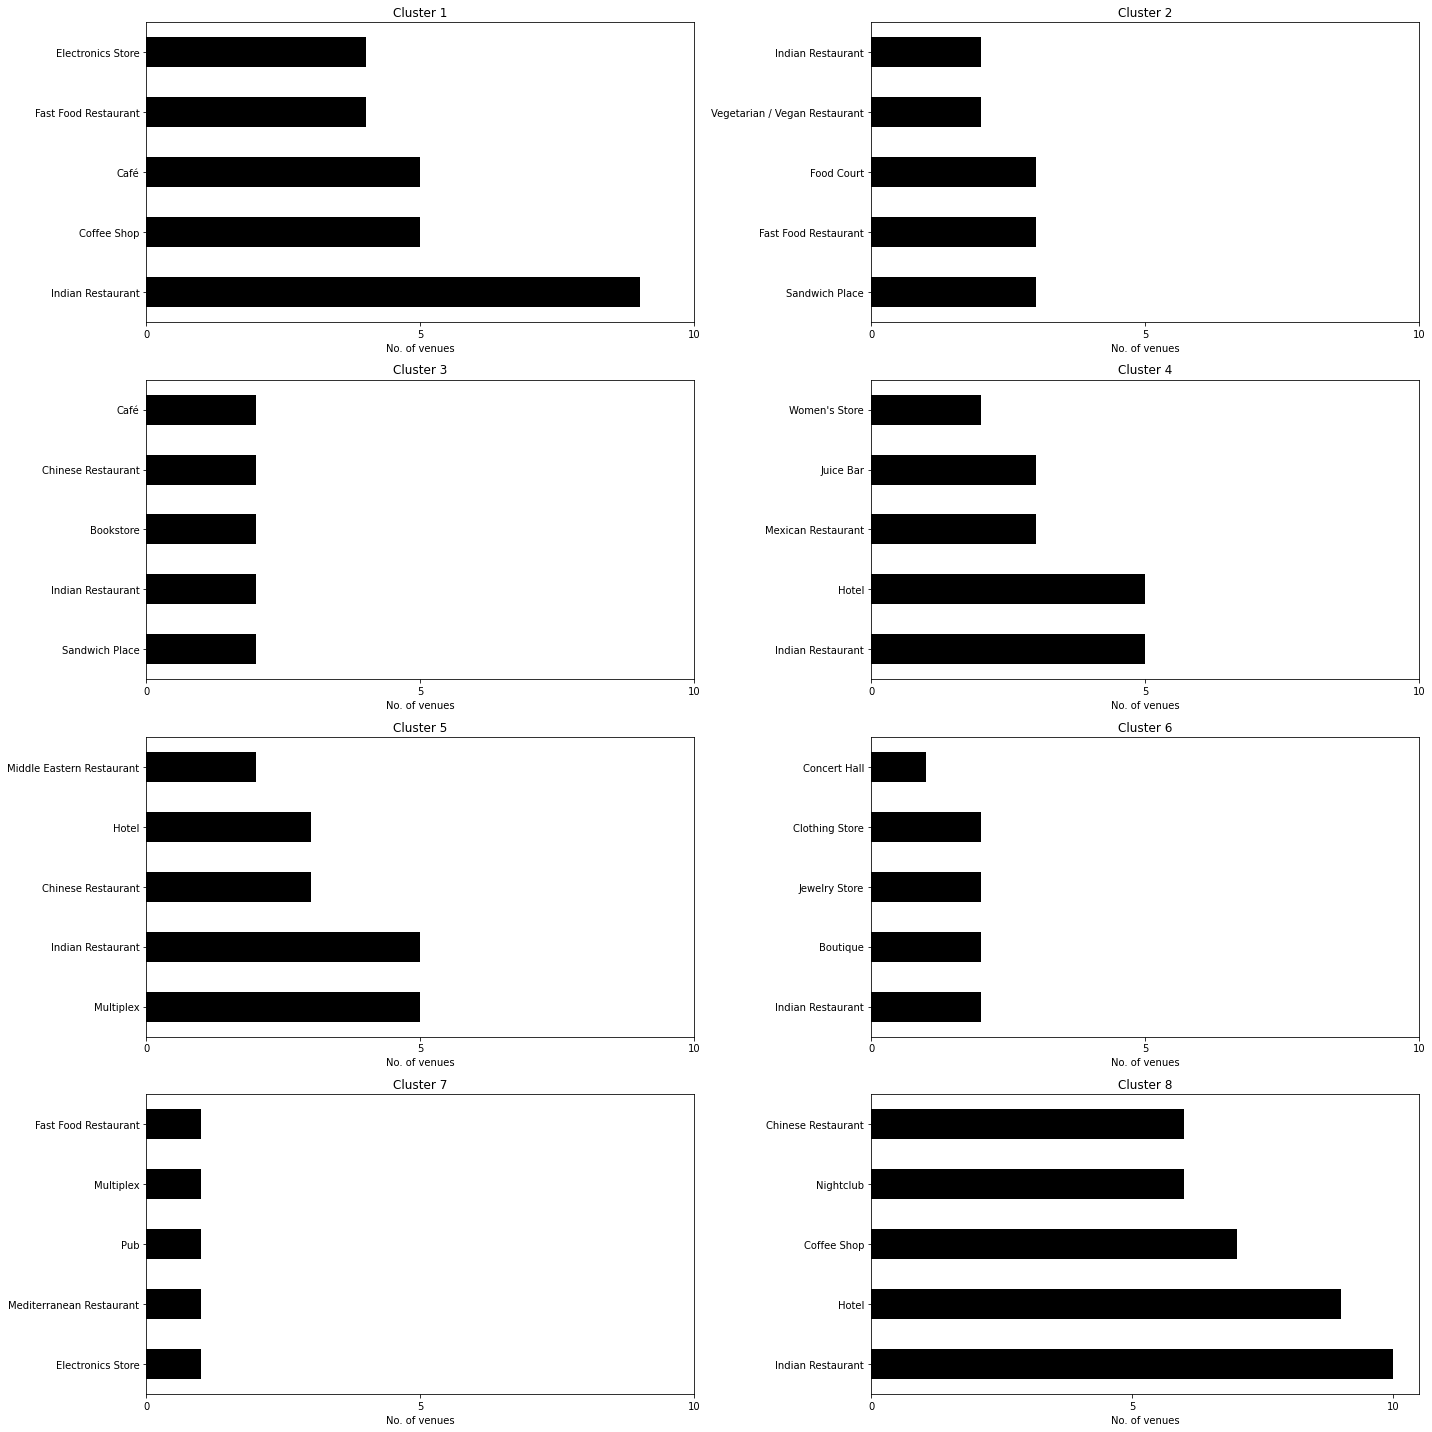

In [175]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(20,20),color='k')
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

# EXAMPLE FOR A BEST OPTION :

## 1. HOTEL:

As we see, since Cluster 1 and Cluster 8 have huge number of hotels, it would be the wrong choice for opening a hotel.
So the perfect option would be Cluster 4 and Cluster 5 as it has a decent number of hotels and most importantly other entertainment zones that also attracts wayfarers towards the hotel.

##### Clusters superimposed on top of map:

This map can be used to find a suitable location to start a new business based on the category.

In [176]:
# create map
chennai_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Neighbourhood Latitude'], chennai_merged['Neighbourhood Longitude'], chennai_merged['Neighbourhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(chennai_clusters_map)
       
chennai_clusters_map

# -----------------------------------------------------------------------------------------------------------------------------------------

# CONCLUSION: <a name="conclusion"></a>

Thus a clustering model(Battle of neighbourhoods) has been successfully developed which is tremendously useful for people with ideas of starting a Business in the discussed fields.
The data realted to the Neighbourhoods of Chennai has been obtained and FourSquare API was used to find the venues of neighbourhoods
As there were certain neighbourhoods with venues < 10 they were dropped and venues > 10 were taken into account.
Clustering is done by using k-nearest algorithm and optimal no. of clusters by silhoutte scoring. 

An example for the project has been discussed. This would be so much useful for people with new and fresh business ideas.